In [2]:
!pip install svgwrite cairosvg pillow


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import svgwrite
import cairosvg
from PIL import Image

# Define the colors used for the polylines
line_colors = ['#000000']  # Adjust this as needed, currently set to black for grayscale

def paths_to_svg(polyline_paths, svg_file):
    max_width, max_height = 0, 0
    for path in polyline_paths:
        for coordinates in path:
            max_width, max_height = max(max_width, np.max(coordinates[:, 0])), max(max_height, np.max(coordinates[:, 1]))
    padding = 0.1
    width, height = int(max_width + padding * max_width), int(max_height + padding * max_height)

    # Create a new SVG drawing with specified size
    drawing = svgwrite.Drawing(svg_file, profile='tiny', size=(width, height), shape_rendering='crispEdges')
    group = drawing.g()

    for index, path in enumerate(polyline_paths):
        path_commands = []
        color = line_colors[index % len(line_colors)]
        for coordinates in path:
            path_commands.append(("M", (coordinates[0, 0], coordinates[0, 1])))
            for j in range(1, len(coordinates)):
                path_commands.append(("L", (coordinates[j, 0], coordinates[j, 1])))
        group.add(drawing.path(d=path_commands, fill='none', stroke=color, stroke_width=2))

    drawing.add(group)
    drawing.save()

    png_file = svg_file.replace('.svg', '.png')
    scale_factor = max(1, 1024 // min(height, width))

    # Convert the SVG to PNG
    cairosvg.svg2png(url=svg_file, write_to=png_file, output_width=scale_factor * width, output_height=scale_factor * height, background_color='white')

    # Convert the PNG to grayscale
    image = Image.open(png_file).convert('L')
    image.save(png_file)
    return png_file

def load_csv(csv_file):
    data = np.genfromtxt(csv_file, delimiter=',')
    polyline_paths = []

    for i in np.unique(data[:, 0]):
        subset = data[data[:, 0] == i][:, 1:]
        path_segments = []
        for j in np.unique(subset[:, 0]):
            segment = subset[subset[:, 0] == j][:, 1:]
            path_segments.append(segment)
        polyline_paths.append(path_segments)

    return polyline_paths

# Example usage
csv_file = 'C:\\Users\\KARAN\\Desktop\\Adobe_Team_7\\problems\\occlusion2.csv'
polyline_paths = load_csv(csv_file)
svg_file = 'polylines.svg'
png_file = paths_to_svg(polyline_paths, svg_file)
print(f"Saved grayscale PNG to {png_file}")

Saved grayscale PNG to polylines.png


Maximum density at distance: 403.85, angle: -0.34 radians


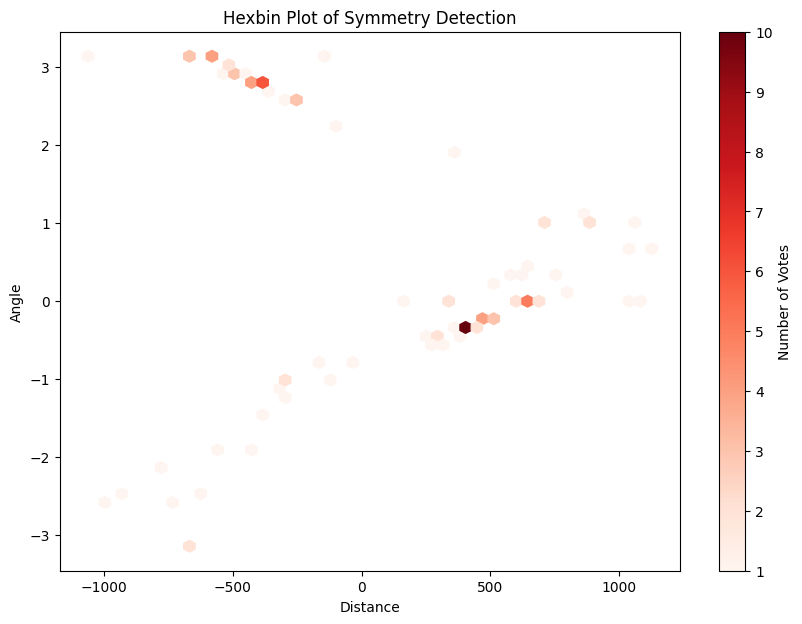

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

sift = cv2.SIFT_create()

# Define the required functions
def points_close(pt1, pt2, threshold=5.0):
    """Returns True if the two points are within a certain threshold distance."""
    return np.linalg.norm(np.array(pt1) - np.array(pt2)) < threshold

def angle_with_horizontal(pt1, pt2):
    """Calculates the angle of the line connecting pt1 and pt2 with the x-axis."""
    dx = pt2[0] - pt1[0]
    dy = pt2[1] - pt1[1]
    return np.arctan2(dy, dx)

def midpoint(pt1, pt2):
    """Calculates the midpoint between two points."""
    return ( (pt1[0] + pt2[0]) / 2, (pt1[1] + pt2[1]) / 2 )

def reisfeld_measure(angle1, angle2, theta):
    """Computes the Reisfeld measure for symmetry."""
    return 1 - np.cos(2 * (angle1 - angle2 - theta))

def scale_factor(size1, size2):
    """Computes the scale factor for symmetry detection."""
    return min(size1, size2) / max(size1, size2)

def detect_symmetry(image):
    """Performs the symmetry detection on image and plots the hexbin plot."""
    mirrored_image = np.fliplr(image)
    keypoints1, descriptors1 = sift.detectAndCompute(image, None)
    keypoints2, descriptors2 = sift.detectAndCompute(mirrored_image, None)
    for kp, mkp in zip(keypoints1, keypoints2):
        kp.angle = np.deg2rad(kp.angle)
        mkp.angle = np.deg2rad(mkp.angle)
    bf_matcher = cv2.BFMatcher()
    matches = bf_matcher.knnMatch(descriptors1, descriptors2, k=2)
    distances = []
    angles = []
    match_weights = []
    good_matches = []

    for match, second_match in matches:
        kp1 = keypoints1[match.queryIdx]
        kp2 = keypoints2[match.trainIdx]
        kp2_alt = keypoints2[second_match.trainIdx]
        kp2_alt.angle = np.pi - kp2_alt.angle
        kp2.angle = np.pi - kp2.angle
        if kp2.angle < 0.0:
            kp2.angle += 2 * np.pi
        if kp2_alt.angle < 0.0:
            kp2_alt.angle += 2 * np.pi
        kp2.pt = (mirrored_image.shape[1] - kp2.pt[0], kp2.pt[1])
        if points_close(kp1.pt, kp2.pt):
            kp2 = kp2_alt
            good_matches.append(second_match)
        else:
            good_matches.append(match)
        angle = angle_with_horizontal(kp1.pt, kp2.pt)
        x_center, y_center = midpoint(kp1.pt, kp2.pt)
        distance = x_center * np.cos(angle) + y_center * np.sin(angle)
        measure = reisfeld_measure(kp1.angle, kp2.angle, angle) * scale_factor(
            kp1.size, kp2.size
        )
        distances.append(distance)
        angles.append(angle)
        match_weights.append(measure)

    distances = np.array(distances)
    angles = np.array(angles)
    match_weights = np.array(match_weights)

    # Plotting the hexbin plot with interactivity
    def plot_hexbin():
        fig, ax = plt.subplots(figsize=(10, 7))
        hexbin = ax.hexbin(distances, angles, gridsize=50, cmap='Reds', mincnt=1)
        plt.title('Hexbin Plot of Symmetry Detection')
        plt.xlabel('Distance')
        plt.ylabel('Angle')
        colorbar = plt.colorbar(hexbin, ax=ax, label='Number of Votes')

        # Find the hexbins with the highest density (darkest color)
        max_counts_idx = np.argmax(hexbin.get_array())
        distance_val = hexbin.get_offsets()[max_counts_idx][0]
        angle_val = hexbin.get_offsets()[max_counts_idx][1]

        print(f"Maximum density at distance: {distance_val:.2f}, angle: {angle_val:.2f} radians")

        plt.show()

    plot_hexbin()

# Example usage
if __name__ == "__main__":
    img = cv2.imread("C:\\Users\\KARAN\\Desktop\\polylines.png", 0)  # Replace with your image path
    sift = cv2.SIFT_create()  # Initialize SIFT detector
    detect_symmetry(img)

In [1]:
import cv2
import numpy as np

sift_detector = cv2.SIFT_create()

def are_points_close(point1, point2, tolerance=4.0):
    """Checks if the points point1, point2 are within tolerance distance of each other."""
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) < tolerance

def scale_factor(size1, size2, sigma=1):
    """Computes the scale factor 'S' based on the research paper."""
    ratio = (-abs(size1 - size2)) / (sigma * (size1 + size2))
    return np.exp(ratio ** 2)

def reisfeld_measure(angle1, angle2, theta):
    """Computes the Reisfeld measure for symmetry."""
    return 1 - np.cos(angle1 + angle2 - 2 * theta)

def compute_midpoint(point1, point2):
    """Calculates the midpoint between two points."""
    return ( (point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2 )

def angle_with_horizontal(point1, point2):
    """Calculates the angle of the line connecting point1 and point2 with the x-axis."""
    delta_x, delta_y = point1[0] - point2[0], point1[1] - point2[1]
    if delta_x == 0:
        return np.pi / 2
    angle = np.arctan(delta_y / delta_x)
    if angle < 0:
        angle += np.pi
    return angle

def detect_symmetry(image):
    """Performs symmetry detection on the image."""
    if image is None:
        raise ValueError("Image not loaded correctly. Please check the file path.")
    
    mirrored_image = np.fliplr(image)
    keypoints1, descriptors1 = sift_detector.detectAndCompute(image, None)
    keypoints2, descriptors2 = sift_detector.detectAndCompute(mirrored_image, None)
    for kp1, kp2 in zip(keypoints1, keypoints2):
        kp1.angle = np.deg2rad(kp1.angle)
        kp2.angle = np.deg2rad(kp2.angle)
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)
    distances = np.zeros(len(matches))
    angles = np.zeros(len(matches))
    match_weights = np.zeros(len(matches))
    valid_matches = []

    for i, (match, second_match) in enumerate(matches):
        keypoint1 = keypoints1[match.queryIdx]
        keypoint2 = keypoints2[match.trainIdx]
        keypoint2_alt = keypoints2[second_match.trainIdx]
        keypoint2_alt.angle = np.pi - keypoint2_alt.angle
        keypoint2.angle = np.pi - keypoint2.angle
        if keypoint2.angle < 0.0:
            keypoint2.angle += 2 * np.pi
        if keypoint2_alt.angle < 0.0:
            keypoint2_alt.angle += 2 * np.pi
        keypoint2.pt = (mirrored_image.shape[1] - keypoint2.pt[0], keypoint2.pt[1])
        if are_points_close(keypoint1.pt, keypoint2.pt):
            keypoint2 = keypoint2_alt
            valid_matches.append(second_match)
        else:
            valid_matches.append(match)
        angle = angle_with_horizontal(keypoint1.pt, keypoint2.pt)
        x_center, y_center = compute_midpoint(keypoint1.pt, keypoint2.pt)
        radius = x_center * np.cos(angle) + y_center * np.sin(angle)
        measure = reisfeld_measure(keypoint1.angle, keypoint2.angle, angle) * scale_factor(
            keypoint1.size, keypoint2.size
        )
        distances[i] = radius
        angles[i] = angle
        match_weights[i] = measure
    valid_matches = sorted(valid_matches, key=lambda x: x.distance)

    def draw_line(radius, angle):
        """Draws the detected line on the image."""
        if np.pi / 4 < angle < 3 * (np.pi / 4):
            for x in range(len(image.T)):
                y = int((radius - x * np.cos(angle)) / np.sin(angle))
                if 0 <= y < len(image.T[x]):
                    image[y][x] = 100
        else:
            for y in range(len(image)):
                x = int((radius - y * np.sin(angle)) / np.cos(angle))
                if 0 <= x < len(image[y]):
                    image[y][x] = 100

    match_image = cv2.drawMatches(image, keypoints1, mirrored_image, keypoints2, valid_matches[:15], None, flags=2)
    draw_line(radius, angle)
    cv2.imshow('Symmetry Detection', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def draw_line_on_image(image, radius, angle):
    """Draws a line on the image based on radius and angle."""
    if np.pi / 4 < angle < 3 * (np.pi / 4):
        for x in range(len(image.T)):
            y = int((radius - x * np.cos(angle)) / np.sin(angle))
            if 0 <= y < len(image.T[x]):
                image[y][x] = 100
    else:
        for y in range(len(image)):
            x = int((radius - y * np.sin(angle)) / np.cos(angle))
            if 0 <= x < len(image[y]):
                image[y][x] = 100

def main(image_path, r=None, theta=None, output_path=None):
    """Main function to handle image processing."""
    print(f"Loading image from path: {image_path}")
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not loaded. Please check the file path.")
        return
    if r is None and theta is None:
        detect_symmetry(image)
    else:
        draw_line_on_image(image, float(r), float(theta))
        if output_path:
            cv2.imwrite(output_path, image)
        else:
            cv2.imshow("Image with Line", image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

# Example usage:
image_path = "C:\\Users\\KARAN\\Desktop\\polylines.png" 
main(image_path)
# To draw a line on the image:
# main(image_path, r=100, theta=1.57)
# To save the image with the line:
# main(image_path, r=100, theta=1.57, output_path="output_image.png")

Loading image from path: C:\Users\KARAN\Desktop\polylines.png


In [ ]:
%%writefile detect.py
import sys
import cv2
import numpy as np

sift_detector = cv2.SIFT_create()

def are_points_close(point1, point2, tolerance=4.0):
    """Checks if the points point1, point2 are within tolerance distance of each other."""
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) < tolerance

def scale_factor(size1, size2, sigma=1):
    """Computes the scale factor 'S' based on the research paper."""
    ratio = (-abs(size1 - size2)) / (sigma * (size1 + size2))
    return np.exp(ratio ** 2)

def reisfeld_measure(angle1, angle2, theta):
    """Computes the Reisfeld measure for symmetry."""
    return 1 - np.cos(angle1 + angle2 - 2 * theta)

def compute_midpoint(point1, point2):
    """Calculates the midpoint between two points."""
    return ( (point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2 )

def angle_with_horizontal(point1, point2):
    """Calculates the angle of the line connecting point1 and point2 with the x-axis."""
    delta_x, delta_y = point1[0] - point2[0], point1[1] - point2[1]
    if delta_x == 0:
        return np.pi / 2
    angle = np.arctan(delta_y / delta_x)
    if angle < 0:
        angle += np.pi
    return angle

def detect_symmetry(image):
    """Performs symmetry detection on the image."""
    mirrored_image = np.fliplr(image)
    keypoints1, descriptors1 = sift_detector.detectAndCompute(image, None)
    keypoints2, descriptors2 = sift_detector.detectAndCompute(mirrored_image, None)

    for kp1, kp2 in zip(keypoints1, keypoints2):
        kp1.angle = np.deg2rad(kp1.angle)
        kp2.angle = np.deg2rad(kp2.angle)

    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)
    distances = np.zeros(len(matches))
    angles = np.zeros(len(matches))
    weights = np.zeros(len(matches))
    good_matches = []

    for match, second_match in matches:
        kp1 = keypoints1[match.queryIdx]
        kp2 = keypoints2[match.trainIdx]
        kp2_alt = keypoints2[second_match.trainIdx]

        kp2_alt.angle = np.pi - kp2_alt.angle
        kp2.angle = np.pi - kp2.angle

        if kp2.angle < 0.0:
            kp2.angle += 2 * np.pi
        if kp2_alt.angle < 0.0:
            kp2_alt.angle += 2 * np.pi

        kp2.pt = (mirrored_image.shape[1] - kp2.pt[0], kp2.pt[1])

        if are_points_close(kp1.pt, kp2.pt):
            kp2 = kp2_alt
            good_matches.append(second_match)
        else:
            good_matches.append(match)

        theta = angle_with_horizontal(kp1.pt, kp2.pt)
        x_center, y_center = compute_midpoint(kp1.pt, kp2.pt)
        radius = x_center * np.cos(theta) + y_center * np.sin(theta)
        measure = reisfeld_measure(kp1.angle, kp2.angle, theta) * scale_factor(
            kp1.size, kp2.size
        )

        distances[i] = radius
        angles[i] = theta
        weights[i] = measure
        i += 1

    good_matches = sorted(good_matches, key=lambda x: x.distance)

    def draw_line(radius, angle):
        """Draws the detected line on the image."""
        if np.pi / 4 < angle < 3 * (np.pi / 4):
            for x in range(len(image[0])):
                y = int((radius - x * np.cos(angle)) / np.sin(angle))
                if 0 <= y < len(image):
                    image[y][x] = 100
        else:
            for y in range(len(image)):
                x = int((radius - y * np.sin(angle)) / np.cos(angle))
                if 0 <= x < len(image[0]):
                    image[y][x] = 100

    matched_image = cv2.drawMatches(image, keypoints1, mirrored_image, keypoints2, good_matches[:15], None, flags=2)
    draw_line(radius, angle)
    cv2.imshow('Symmetry Detection', image)
    cv2.waitKey(0)

def main():
    """Main function to handle command-line arguments and execute appropriate functionality."""
    arg_count = len(sys.argv)
    if not (arg_count == 2 or arg_count == 4 or arg_count == 5):
        print("Usage: python3 detect.py IMAGE [r] [theta]")
        return
    if arg_count == 2:
        detect_symmetry(cv2.imread(sys.argv[1], 0))
    elif arg_count == 4:
        img = cv2.imread(sys.argv[1], 0)
        draw_line(img, float(sys.argv[2]), float(sys.argv[3]))
        cv2.imshow("Image with Line", img)
        cv2.waitKey(0)
    else:
        img = cv2.imread(sys.argv[1], 0)
        draw_line(img, float(sys.argv[2]), float(sys.argv[3]))
        cv2.imwrite("{}".format(sys.argv[4]), img)

if __name__ == "__main__":
    main()
